## Convolutional & Conditional VAEs

In this problem you will implement: 
1. a **convolutional** variational autoencoder
2. a (convolutional) **conditional** variational autoencoder,

trained on the MNIST dataset. 
The convolutional parameterization will help you achieve better marginal log likelihood. Using the conditional VAE, you'll be able to generate novel images of a specified class.


In [1]:
%pylab inline
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.distributions import MultivariateNormal

Populating the interactive namespace from numpy and matplotlib


In [2]:
batch_size = 256

# train_loader = torch.utils.data.DataLoader(
#     MNIST('./data', train=True, download=True, 
#           transform=transforms.ToTensor()),
#     batch_size=batch_size, shuffle=True)

train_set, valid_set = torch.utils.data.random_split(MNIST('./data', train=True, download=True, 
          transform=transforms.ToTensor()), [50000, 10000])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True
)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...


/home/rahulahuja/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!




---
# 1. Convolutional variational autoencoder (20 points)


Your task is to implement a VAE for MNIST, using a **convolutional network** in the encoder, and a **convolutional network** in the decoder.

- **Overall Goal:** achieve better estimated marginal likelihood than in the lab
  - Keep `z=20` as in the lab 


**Encoder**: you are free to design the convolutional network how you want. 
  - We used three `Conv2d + ReLU` layers, with an output size of `B x 64 x 7 x 7`.
  - Hint: Flatten the output of your convolutional network before mapping it to the encoder outputs, e.g. $\mu = \texttt{linear(flatten(conv(x)))}$


**Decoder**: you are free to design the convolutional network how you want. 
  - We used three `ConvTranspose2d + ReLU` layers, with an input size of `B x 64 x 7 x 7`.
  - Hint: Map the $\mathbf{z}$ input to the convolutional input size.
    - $\hat{x}=\texttt{deconv(reshape(linear(z)))}$

In [3]:
x_sample = iter(train_loader).next()
print(x_sample[0].shape, x_sample[1].shape)

torch.Size([256, 1, 28, 28]) torch.Size([256])


In [31]:
class Encoder(nn.Module):
    def __init__(self, zdim):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(1,16,3,padding = 1), nn.LeakyReLU())
        self.conv2 = nn.Sequential(nn.Conv2d(16,32,3,stride = 2, padding = 1), nn.LeakyReLU())
        self.conv3 = nn.Sequential(nn.Conv2d(32,64,3,stride = 2, padding = 1), nn.LeakyReLU())
        hdim = (28//4)**2*64
        self.mu = nn.Linear(hdim, zdim)
        self.logvar = nn.Linear(hdim, zdim)
        self.zdim = zdim
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        h = self.conv3(out).view(x.shape[0],-1)
        mu = self.mu(h)
        logvar = self.logvar(h)
        return mu,logvar


class Decoder(nn.Module):
    def __init__(self, zdim):
        super().__init__()
        hdim = (28//4)**2*64
        self.linear = nn.Linear(zdim, hdim)
        self.convt1 = nn.Sequential(nn.ConvTranspose2d(64,32,2,stride = 2, padding = 0), nn.LeakyReLU())
        self.convt2 = nn.Sequential(nn.ConvTranspose2d(32,16,2,stride = 2, padding = 0), nn.LeakyReLU())
        self.convt3 = nn.Sequential(nn.ConvTranspose2d(16,1,3,stride = 1, padding = 1), nn.Sigmoid())

    def forward(self, x):
        out = self.linear(x).view(x.shape[0],64,7,7)
        out = self.convt1(out)
        out = self.convt2(out)
        out = self.convt3(out)
        return out

class VAE(nn.Module):
    def __init__(self,zdim):
        super().__init__()
        self.encoder = Encoder(zdim)
        self.decoder = Decoder(zdim)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            z = mu + std*eps
        else:
            z = mu
        return z

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        xhat = self.decoder(z)
        return xhat, mu, logvar

**Loss**: does anything change from the lab?
- Same equation, but need a shape change

In [32]:
# hint: see lab

def loss_function(xhat, x, mu, logvar, kl_weight=1.0):
    BCE = nn.functional.binary_cross_entropy(xhat.view(x.size(0), -1), x.view(x.size(0), -1), reduction='none').sum(1).mean()
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), 1).mean()

    loss = BCE + kl_weight*KLD
    return loss, BCE, KLD

**Train on MNIST**: does anything change from the lab?

**Your task:** Implement training logic, and *produce a plot of training loss and a plot of validation loss* (x-axis: epoch, y-axis: loss). Each plot should contain three lines: total loss, BCE, and KL-divergence.

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
zdim = 20        # use this
kl_weight = 1.0  # use this

Using device: cuda


In [38]:
def train(epoch, model, train_loader, learning_rate):
    log_interval = 50
    optimizer = torch.optim.Adam(
        model.parameters(), lr=learning_rate)

    model.train()
    epoch_train_loss, epoch_train_bce_loss, epoch_train_kld_loss = 0,0,0
    for i, data in enumerate(train_loader):
        images,_ = data
        images = images.to(device)
        outputs, mu, logvar = model(images)
        loss, bce, kld = loss_function(outputs, images, mu, logvar, kl_weight)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss
        epoch_train_bce_loss += bce
        epoch_train_kld_loss += kld

        if (i + 1) % log_interval == 0:
            print('Epoch [{}/{}] - Iter[{}/{}], loss:{:.6f}'.format(
                epoch + 1, num_epoch, i + 1,
                len(train_loader), epoch_train_loss.item()/(i+1)
            ))
            
    epoch_train_loss = epoch_train_loss.detach().cpu().numpy()/len(train_loader)
    epoch_train_bce_loss = epoch_train_bce_loss.detach().cpu().numpy()/len(train_loader)
    epoch_train_kld_loss = epoch_train_kld_loss.detach().cpu().numpy()/len(train_loader)
    
    return epoch_train_loss, epoch_train_bce_loss, epoch_train_kld_loss


def valid(epoch, model, valid_loader, save_path):
    model.eval()
    epoch_val_loss, epoch_val_bce_loss, epoch_val_kld_loss = 0,0,0
    with torch.no_grad():
        for i, data in enumerate(valid_loader):
            images, _ = data
            images = images.to(device)
            outputs, mu, logvar = model(images)
            loss, bce, kld = loss_function(outputs, images, mu, logvar, kl_weight)
            epoch_val_loss += loss
            epoch_val_bce_loss += bce
            epoch_val_kld_loss += kld
    epoch_val_loss = epoch_val_loss.detach().cpu().numpy()/len(valid_loader)
    epoch_val_bce_loss = epoch_val_bce_loss.detach().cpu().numpy()/len(valid_loader)
    epoch_val_kld_loss = epoch_val_kld_loss.detach().cpu().numpy()/len(valid_loader)
    print('\nLoss per batch on validation set: {:.6f}'.format(epoch_val_loss))
    
    return epoch_val_loss, epoch_val_bce_loss, epoch_val_kld_loss


In [39]:
model = VAE(zdim)
model.to(device)

num_epoch = 100
learning_rate = 1e-3
max_patience = 5
patience_counter = 0
best_val_loss = float('inf')
save_path = './vae.pth'

val_bce_loss_record = []
val_kld_loss_record = []
train_bce_loss_record = []
train_kld_loss_record = []

for epoch in range(num_epoch):
    start_time = datetime.datetime.now()
    epoch_train_loss, epoch_train_bce_loss, epoch_train_kld_loss = train(epoch, model, train_loader, learning_rate)
    end_time = datetime.datetime.now()
    print(f'Trained this epoch using {(end_time - start_time).seconds} seconds')
    # validate and save model if it's the best model so far
    epoch_val_loss, epoch_val_bce_loss, epoch_val_kld_loss = valid(epoch, model, train_loader, save_path)
    
    train_bce_loss_record.append(epoch_train_bce_loss)
    train_kld_loss_record.append(epoch_train_kld_loss)
    val_bce_loss_record.append(epoch_val_bce_loss)
    val_kld_loss_record.append(epoch_val_kld_loss)
    
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), save_path)
        print('Saved best model in the checkpoint directory\n')
        patience_counter = 0
    else:
        patience_counter += 1    
        if patience_counter > max_patience: 
            break

print('Training done; best validation loss {:.4f}'.format(best_val_loss))

Epoch [1/100] - Iter[50/196], loss:326.023770
Epoch [1/100] - Iter[100/196], loss:266.424121
Epoch [1/100] - Iter[150/196], loss:235.733932
Trained this epoch using 5 seconds

Loss per batch on validation set: 131.960150
Saved best model in the checkpoint directory

Epoch [2/100] - Iter[50/196], loss:137.250313
Epoch [2/100] - Iter[100/196], loss:133.202246
Epoch [2/100] - Iter[150/196], loss:129.961732
Trained this epoch using 5 seconds

Loss per batch on validation set: 110.038993
Saved best model in the checkpoint directory

Epoch [3/100] - Iter[50/196], loss:121.468496
Epoch [3/100] - Iter[100/196], loss:119.528105
Epoch [3/100] - Iter[150/196], loss:118.408893
Trained this epoch using 5 seconds

Loss per batch on validation set: 105.902872
Saved best model in the checkpoint directory

Epoch [4/100] - Iter[50/196], loss:116.606436
Epoch [4/100] - Iter[100/196], loss:115.323359
Epoch [4/100] - Iter[150/196], loss:114.564219
Trained this epoch using 5 seconds

Loss per batch on valid

Epoch [33/100] - Iter[150/196], loss:101.478027
Trained this epoch using 5 seconds

Loss per batch on validation set: 92.458855
Saved best model in the checkpoint directory

Epoch [34/100] - Iter[50/196], loss:101.631455
Epoch [34/100] - Iter[100/196], loss:101.485283
Epoch [34/100] - Iter[150/196], loss:101.339746
Trained this epoch using 5 seconds

Loss per batch on validation set: 92.530951
Epoch [35/100] - Iter[50/196], loss:101.314814
Epoch [35/100] - Iter[100/196], loss:101.226611
Epoch [35/100] - Iter[150/196], loss:101.204297
Trained this epoch using 5 seconds

Loss per batch on validation set: 92.699169
Epoch [36/100] - Iter[50/196], loss:101.910098
Epoch [36/100] - Iter[100/196], loss:101.512285
Epoch [36/100] - Iter[150/196], loss:101.411152
Trained this epoch using 5 seconds

Loss per batch on validation set: 92.409399
Saved best model in the checkpoint directory

Epoch [37/100] - Iter[50/196], loss:101.259512
Epoch [37/100] - Iter[100/196], loss:101.106309
Epoch [37/100] -

Epoch [68/100] - Iter[150/196], loss:99.151400
Trained this epoch using 5 seconds

Loss per batch on validation set: 90.784000
Epoch [69/100] - Iter[50/196], loss:99.417871
Epoch [69/100] - Iter[100/196], loss:99.309521
Epoch [69/100] - Iter[150/196], loss:99.158516
Trained this epoch using 5 seconds

Loss per batch on validation set: 91.171636
Epoch [70/100] - Iter[50/196], loss:99.309463
Epoch [70/100] - Iter[100/196], loss:99.050010
Epoch [70/100] - Iter[150/196], loss:98.975098
Trained this epoch using 5 seconds

Loss per batch on validation set: 90.706134
Epoch [71/100] - Iter[50/196], loss:99.579053
Epoch [71/100] - Iter[100/196], loss:99.167441
Epoch [71/100] - Iter[150/196], loss:99.004948
Trained this epoch using 5 seconds

Loss per batch on validation set: 90.423489
Epoch [72/100] - Iter[50/196], loss:99.231699
Epoch [72/100] - Iter[100/196], loss:98.969873
Epoch [72/100] - Iter[150/196], loss:99.051322
Trained this epoch using 5 seconds

Loss per batch on validation set: 90.

Text(0.5, 1.0, 'Validation Loss')

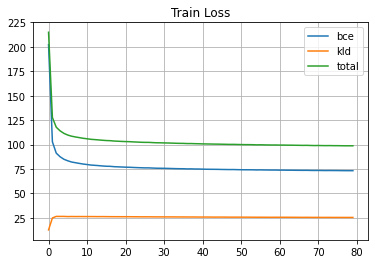

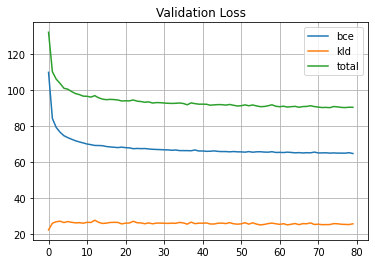

In [45]:
plt.figure()
plt.plot(train_bce_loss_record, label = 'bce')
plt.plot(train_kld_loss_record, label = 'kld')
plt.plot(np.array(train_bce_loss_record)+kl_weight*np.array(train_kld_loss_record), label = 'total')
plt.legend()
plt.grid()
plt.title('Train Loss')

plt.figure()
plt.plot(val_bce_loss_record, label = 'bce')
plt.plot(val_kld_loss_record, label = 'kld')
plt.plot(np.array(val_bce_loss_record)+kl_weight*np.array(val_kld_loss_record), label = 'total')
plt.legend()
plt.grid()
plt.title('Validation Loss')

### Evaluation
- **We provide the code below for sampling, interpolation, and marginal likelihood estimation**
- Sampling and interpolation: achieve similar to the lab (this is subjective, so the purpose is to check if something is *way off*)
- Marginal likelihood: achieve better than the lab



*Please ensure that `model` contains the model state that you will use for evaluation before running these.*

#### Sampling

*no code modification needed*

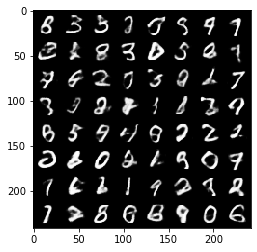

In [46]:
from torchvision.utils import make_grid

N = 64
model.eval()

# Sample z~p(z)
z = torch.randn((N, model.encoder.zdim)).to(device)

# Decode
sample = model.decoder(z)

# Visualize
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

imgs = sample
grid = make_grid(imgs).detach().cpu()
show(grid)

#### Interpolation

*no code modification needed*

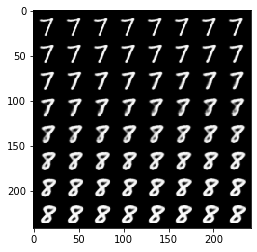

In [48]:
model.eval()

x, y = next(train_loader.__iter__())
xhat, mu, logvar = model(x.cuda())
si, ei = np.random.choice(batch_size, size=2, replace=False)
start = mu[si]
end = mu[ei]

N = 64

zs = torch.zeros(N, model.encoder.zdim).to(device)
for i in range(N):
    zs[i] = i / (N) * start.data + (1 - i / (N) ) * end.data
xhat = model.decoder(zs)

imgs = xhat.unsqueeze(0).unsqueeze(0).view(N, 1, 28, 28)
grid = make_grid(imgs).detach().cpu()
show(grid)

#### Marginal likelihood

*no code modification needed*

In [50]:
from tqdm import tqdm_notebook

torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

eval_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=1, shuffle=True)

N_samples = 128

model.eval()
results = []
with torch.no_grad():
    for i, (x, y) in tqdm_notebook(enumerate(eval_loader), total=len(eval_loader)):
        x, y = next(eval_loader.__iter__())
        x = x.to(device).expand(N_samples, 1, 28, 28)

        # Obtain mu, logvar and sample z
        _, mu, logvar = model(x)
        z = mu + logvar.mul(0.5).exp()*torch.randn_like(mu)

        # Obtain xhat given the sampled z
        xhat = model.decoder(z)

        # Make a standard normal for p(z) and a normal for q(z|x)
        norm = MultivariateNormal(
            torch.zeros_like(mu[0]), 
            covariance_matrix=torch.diag(torch.ones_like(logvar[0]))
        )
        mvn = MultivariateNormal(
            mu[0], 
            covariance_matrix=torch.diag(logvar.exp()[0])
        )

        # Measure the (log) probabilities needed for the formula above
        log_pz = norm.log_prob(z)
        log_qzx = mvn.log_prob(z)
        x = x.view(xhat.size())
        log_pxz = -nn.functional.binary_cross_entropy(
            xhat, x, reduction='none'
        ).view(N_samples, -1).sum(1)

        # Compute the lowerbound (in log space)
        argsum = log_pxz + log_pz - log_qzx
        logpx = -np.log(N_samples) + torch.logsumexp(argsum, 0)
        results.append(logpx.item())

np.mean(results)

<ipython-input-50-ed2760af90da>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, (x, y) in tqdm_notebook(enumerate(eval_loader), total=len(eval_loader)):


-94.44939053382873



---

# 2. Conditional variational autoencoder (20 points)

### A. Model

The conditional VAE involves:
- $q_{\phi}(\mathbf{z}|\mathbf{x},c)$: "encoder"
- $p_{\theta}(\mathbf{x}|\mathbf{z},c)$: "decoder"
- $p(\mathbf{z})$: prior

In our case, $c\in \{0,...,9\}$ is a discrete variable (class label).

**Your task:** Implement a `CVAE` that has an `encoder`, `decoder`, and `reparameterization`.

*Hints*: 
  1. Represent $c$ using a `nn.Embedding` layer, and concatenate it to the representation of $\mathbf{x}$.
    - e.g. $\mu = \texttt{linear([conv(x); emb(c)])}$
  2. Represent `decoder` inputs $\mathbf{z},c$ similarly, as $[\mathbf{z};\text{emb}(c)]$.
    - $\hat{x}=\texttt{deconv(linear([z; emb(c)]))}$

Otherwise, everything else is the same as VAE (plus passing $c$ as an argument in the right places). You can use the same convolutional layers as above.

In [8]:
class Encoder(nn.Module):
    def __init__(self, zdim, nclasses):
        super().__init__()
        embedding_dim = 10
        self.conv1 = nn.Sequential(nn.Conv2d(1,16,3,padding = 1), nn.LeakyReLU())
        self.conv2 = nn.Sequential(nn.Conv2d(16,32,3,stride = 2, padding = 1), nn.LeakyReLU())
        self.conv3 = nn.Sequential(nn.Conv2d(32,64,3,stride = 2, padding = 1), nn.LeakyReLU())
        self.embedding = nn.Embedding(num_embeddings = nclasses, embedding_dim = embedding_dim)
        hdim = (28//4)**2*64
        self.mu = nn.Linear(hdim+embedding_dim, zdim)
        self.logvar = nn.Linear(hdim+embedding_dim, zdim)
        self.zdim = zdim
        
    def forward(self, x, c):
        out = self.conv1(x)
        out = self.conv2(out)
        h = self.conv3(out).view(x.shape[0],-1)
        h = torch.cat([h, self.embedding(c)], axis = 1)
        mu = self.mu(h)
        logvar = self.logvar(h)
        return mu,logvar


class Decoder(nn.Module):
    def __init__(self, zdim, nclasses):
        super().__init__()
        hdim = (28//4)**2*64
        embedding_dim = 10
        self.embedding = nn.Embedding(num_embeddings = nclasses, embedding_dim = embedding_dim)
        self.linear = nn.Linear(zdim+embedding_dim, hdim)
        self.convt1 = nn.Sequential(nn.ConvTranspose2d(64,32,2,stride = 2, padding = 0), nn.LeakyReLU())
        self.convt2 = nn.Sequential(nn.ConvTranspose2d(32,16,2,stride = 2, padding = 0), nn.LeakyReLU())
        self.convt3 = nn.Sequential(nn.ConvTranspose2d(16,1,3,stride = 1, padding = 1), nn.Sigmoid())

    def forward(self, x, c):
        x = torch.cat([x,self.embedding(c)], axis = 1)
        out = self.linear(x).view(x.shape[0],64,7,7)
        out = self.convt1(out)
        out = self.convt2(out)
        out = self.convt3(out)
        return out

class CVAE(nn.Module):
    def __init__(self,zdim, nclasses):
        super().__init__()
        self.encoder = Encoder(zdim, nclasses)
        self.decoder = Decoder(zdim, nclasses)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            z = mu + std*eps
        else:
            z = mu
        return z

    def forward(self, x, c):
        mu, logvar = self.encoder(x, c)
        z = self.reparameterize(mu, logvar)
        xhat = self.decoder(z, c)
        return xhat, mu, logvar

**Loss:** same as VAE.

In [9]:
def loss_function(xhat, x, mu, logvar, kl_weight=1.0):
    BCE = nn.functional.binary_cross_entropy(xhat.view(x.size(0), -1), x.view(x.size(0), -1), reduction='none').sum(1).mean()
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), 1).mean()

    loss = BCE + kl_weight*KLD
    return loss, BCE, KLD

### C. Training

Train your conditional VAE model using your loss function on MNIST.

**Your task:** Implement training logic, and *produce a plot of training loss and a plot of validation loss* (x-axis: epoch, y-axis: loss). Each plot should contain three lines: total loss, BCE, and KL-divergence.


In [10]:
def train(epoch, model, train_loader, learning_rate):
    log_interval = 50
    optimizer = torch.optim.Adam(
        model.parameters(), lr=learning_rate)

    model.train()
    epoch_train_loss, epoch_train_bce_loss, epoch_train_kld_loss = 0,0,0
    for i, data in enumerate(train_loader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs, mu, logvar = model(images, labels)
        loss, bce, kld = loss_function(outputs, images, mu, logvar, kl_weight)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss
        epoch_train_bce_loss += bce
        epoch_train_kld_loss += kld

        if (i + 1) % log_interval == 0:
            print('Epoch [{}/{}] - Iter[{}/{}], loss:{:.6f}'.format(
                epoch + 1, num_epoch, i + 1,
                len(train_loader), epoch_train_loss.item()/(i+1)
            ))
            
    epoch_train_loss = epoch_train_loss.detach().cpu().numpy()/len(train_loader)
    epoch_train_bce_loss = epoch_train_bce_loss.detach().cpu().numpy()/len(train_loader)
    epoch_train_kld_loss = epoch_train_kld_loss.detach().cpu().numpy()/len(train_loader)
    
    return epoch_train_loss, epoch_train_bce_loss, epoch_train_kld_loss


def valid(epoch, model, valid_loader, save_path):
    model.eval()
    epoch_val_loss, epoch_val_bce_loss, epoch_val_kld_loss = 0,0,0
    with torch.no_grad():
        for i, data in enumerate(valid_loader):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs, mu, logvar = model(images, labels)
            loss, bce, kld = loss_function(outputs, images, mu, logvar, kl_weight)
            epoch_val_loss += loss
            epoch_val_bce_loss += bce
            epoch_val_kld_loss += kld
    epoch_val_loss = epoch_val_loss.detach().cpu().numpy()/len(valid_loader)
    epoch_val_bce_loss = epoch_val_bce_loss.detach().cpu().numpy()/len(valid_loader)
    epoch_val_kld_loss = epoch_val_kld_loss.detach().cpu().numpy()/len(valid_loader)
    print('\nLoss per batch on validation set: {:.6f}'.format(epoch_val_loss))
    
    return epoch_val_loss, epoch_val_bce_loss, epoch_val_kld_loss


In [11]:
model = CVAE(zdim, 10)
model.to(device)

num_epoch = 100
learning_rate = 1e-3
max_patience = 5
patience_counter = 0
best_val_loss = float('inf')
save_path = './cvae.pth'

val_bce_loss_record = []
val_kld_loss_record = []
train_bce_loss_record = []
train_kld_loss_record = []

for epoch in range(num_epoch):
    start_time = datetime.datetime.now()
    epoch_train_loss, epoch_train_bce_loss, epoch_train_kld_loss = train(epoch, model, train_loader, learning_rate)
    end_time = datetime.datetime.now()
    print(f'Trained this epoch using {(end_time - start_time).seconds} seconds')
    # validate and save model if it's the best model so far
    epoch_val_loss, epoch_val_bce_loss, epoch_val_kld_loss = valid(epoch, model, train_loader, save_path)
    
    train_bce_loss_record.append(epoch_train_bce_loss)
    train_kld_loss_record.append(epoch_train_kld_loss)
    val_bce_loss_record.append(epoch_val_bce_loss)
    val_kld_loss_record.append(epoch_val_kld_loss)
    
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), save_path)
        print('Saved best model in the checkpoint directory\n')
        patience_counter = 0
    else:
        patience_counter += 1    
        if patience_counter > max_patience: 
            break

print('Training done; best validation loss {:.4f}'.format(best_val_loss))

Epoch [1/100] - Iter[50/196], loss:291.454648
Epoch [1/100] - Iter[100/196], loss:237.403613
Epoch [1/100] - Iter[150/196], loss:212.315299
Trained this epoch using 7 seconds

Loss per batch on validation set: 130.964435
Saved best model in the checkpoint directory

Epoch [2/100] - Iter[50/196], loss:136.959414
Epoch [2/100] - Iter[100/196], loss:132.570518
Epoch [2/100] - Iter[150/196], loss:129.125807
Trained this epoch using 6 seconds

Loss per batch on validation set: 108.951421
Saved best model in the checkpoint directory

Epoch [3/100] - Iter[50/196], loss:118.840400
Epoch [3/100] - Iter[100/196], loss:117.099014
Epoch [3/100] - Iter[150/196], loss:115.927878
Trained this epoch using 6 seconds

Loss per batch on validation set: 102.708566
Saved best model in the checkpoint directory

Epoch [4/100] - Iter[50/196], loss:113.253389
Epoch [4/100] - Iter[100/196], loss:111.897881
Epoch [4/100] - Iter[150/196], loss:111.112227
Trained this epoch using 6 seconds

Loss per batch on valid

Epoch [33/100] - Iter[150/196], loss:96.380697
Trained this epoch using 5 seconds

Loss per batch on validation set: 87.591568
Saved best model in the checkpoint directory

Epoch [34/100] - Iter[50/196], loss:96.609141
Epoch [34/100] - Iter[100/196], loss:96.249590
Epoch [34/100] - Iter[150/196], loss:96.166797
Trained this epoch using 5 seconds

Loss per batch on validation set: 88.398667
Epoch [35/100] - Iter[50/196], loss:96.928848
Epoch [35/100] - Iter[100/196], loss:96.432666
Epoch [35/100] - Iter[150/196], loss:96.185944
Trained this epoch using 5 seconds

Loss per batch on validation set: 87.746273
Epoch [36/100] - Iter[50/196], loss:96.074834
Epoch [36/100] - Iter[100/196], loss:95.986797
Epoch [36/100] - Iter[150/196], loss:95.950560
Trained this epoch using 6 seconds

Loss per batch on validation set: 87.749591
Epoch [37/100] - Iter[50/196], loss:95.957852
Epoch [37/100] - Iter[100/196], loss:95.913018
Epoch [37/100] - Iter[150/196], loss:95.729740
Trained this epoch using 5 

Text(0.5, 1.0, 'Validation Loss')

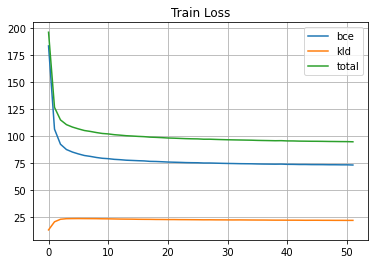

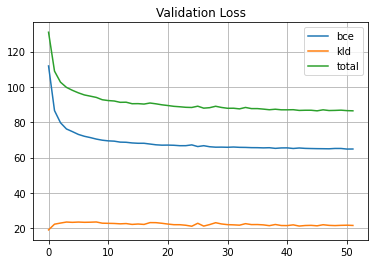

In [12]:
plt.figure()
plt.plot(train_bce_loss_record, label = 'bce')
plt.plot(train_kld_loss_record, label = 'kld')
plt.plot(np.array(train_bce_loss_record)+kl_weight*np.array(train_kld_loss_record), label = 'total')
plt.legend()
plt.grid()
plt.title('Train Loss')

plt.figure()
plt.plot(val_bce_loss_record, label = 'bce')
plt.plot(val_kld_loss_record, label = 'kld')
plt.plot(np.array(val_bce_loss_record)+kl_weight*np.array(val_kld_loss_record), label = 'total')
plt.legend()
plt.grid()
plt.title('Validation Loss')

### D. Conditional generation

**Your task**: complete the code below to produce a grid of samples with 10 rows, where the $i$'th row has samples of class $i$.

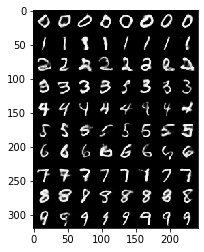

In [15]:
from torchvision.utils import make_grid
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')


N = 8
model.eval()
grids = []
for y_ in range(10):
  
    z = torch.randn((N, model.encoder.zdim)).to(device)
    y = y_*torch.ones((z.shape[0]), dtype=torch.long).to(device)
    sample = model.decoder(z, y)

    grid = make_grid(sample).detach().cpu()
    grids.append(grid)

grid = torch.cat(grids, 1)
show(grid);